In [582]:
%matplotlib inline  
import os
import random
import time

from glob import glob
from itertools import accumulate

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from skimage.measure import ransac
from skimage.transform import AffineTransform
from skimage.transform import SimilarityTransform
from skimage.transform import FundamentalMatrixTransform

from tqdm import tqdm

# Important Links:
 - [SIFT](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html)
 - [ORB](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html)

In [583]:
dataset_root = os.path.join('data', 'dataset')
dataset_all = os.path.join(dataset_root, '*')

In [584]:
def get_boundaries(ix, acc_ix):
    start = acc_ix[acc_ix <= ix][-1]
    stop = acc_ix[acc_ix > ix][0]
    return [start, stop]


def get_dataset_index(ix, acc_ix):
    return (acc_ix <= ix).sum() - 1


def get_classes(root):
    classes = glob(os.path.join(dataset_root, '*'))
    classes.sort()
    classes = map(lambda path: os.path.basename(path), classes)
    return list(classes)


def get_image_distance(image_kps, database_kps, database_points=[], k=100):
    k_distances = []
    
    if len(database_points) <= 0:
        database_points = get_point_mat(database_kps)
    
    for kp1 in image_kps:
        query_point = np.array(kp1.pt)
        distance = np.linalg.norm(database_points-query_point, axis=1)
        ix_top = np.argsort(distance)[:k]
        k_distances.append(ix_top)
    return(np.array(k_distances))


def get_image_distance_vectorized(image_kps, database_kps, database_points=[], k=100):
    query_points = get_point_mat(image_kps)[:, None]
    
    if len(database_points) <= 0:
        database_points = get_point_mat(database_kps)
        
    distances = np.linalg.norm(database_points-query_points, axis=-1)
    ix_distances = np.argsort(distances, axis=-1)
    return(ix_distances[:, :k])


def get_class_mapping(classes, labels):
    mapper = {}
    for i, label in enumerate(labels):
        mapper[classes[i]] = label
    return mapper


def get_point_mat(kps, rank=2):
    points = []
    if rank == 3:
        for kps_list in kps:
            points.append(get_point_mat(kps_list, rank=2))
    else:    
        for kp in kps:
            if kp == None:
                points.append(np.array([float('inf'), float('inf')]) )
            else:
                points.append(np.array(kp.pt))    
    return(np.array(points))


def get_kps_distance(kps1, kps2):
    x1, y1 = kps1.pt
    x2, y2 = kps2.pt
    xn, yn = [x1-x2, y1-y2] 
    return np.linalg.norm([xn, yn])


def get_matches(query, db_image, detector, ratio=0.7):
    kps1, des1 = detector.detectAndCompute(query, None)
    kps2, des2 = detector.detectAndCompute(db_image, None)
    
    # Find Similarities
    FLANN_INDEX_LINEAR = 0
    FLANN_INDEX_KDTREE = 1
    FLANN_INDEX_KMEANS = 2
    FLANN_INDEX_COMPOSITE = 3
    FLANN_INDEX_KDTREE_SINGLE = 4
    FLANN_INDEX_HIERARCHICAL = 5
    FLANN_INDEX_LSH = 6
    FLANN_INDEX_SAVED = 254
    FLANN_INDEX_AUTOTUNED = 255
    index_params = dict(algorithm=FLANN_INDEX_KMEANS)
    search_params = dict(checks=50)

    try:
        flann = cv.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(des1.astype(np.float32), 
                                 des2.astype(np.float32), k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m, n in matches:
            if m.distance < ratio*n.distance:
                good.append(m)
    except:
        good = []
    
    return kps1, kps2, good

def get_inliers(matches, min_match_count=10):
    matchesMask = None
    
    if len(matches) >= min_match_count:
        src_pts = np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        dst_pts = np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
    return matchesMask


def get_labels(classes):
    return list(range(0, len(classes)))


def load_dataset(dataset_root, class_mapper):
    dataset = []
    for root, dirs, files in os.walk(dataset_root):
        if len(files) > 0:
            for image_name in files:
                class_name = os.path.basename(root)
                label = class_mapper[class_name]
                path = os.path.join(root, image_name)
                dataset.append([path, label])
    return dataset

In [585]:
classes = get_classes(glob(dataset_all))
classes

['car', 'cat', 'dog', 'house', 'tulip']

In [586]:
labels = get_labels(classes)
labels

[0, 1, 2, 3, 4]

In [587]:
class_mapper = get_class_mapping(classes, labels)
class_mapper

{'car': 0, 'cat': 1, 'dog': 2, 'house': 3, 'tulip': 4}

In [588]:
dataset = load_dataset(dataset_root, class_mapper)
dataset.sort(key=lambda x: x[1])
dataset[:5]

[['data/dataset/car/2649449358_fed712e03d.jpg', 0],
 ['data/dataset/car/145848224_3333ac0525.jpg', 0],
 ['data/dataset/car/2060355619_4171747795.jpg', 0],
 ['data/dataset/car/195987340_deadffe423.jpg', 0],
 ['data/dataset/car/2508563797_7da0a8cb99.jpg', 0]]

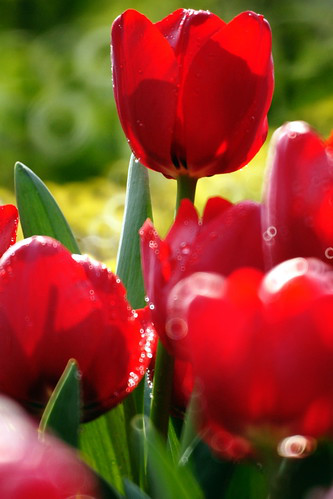

In [589]:
image, label = dataset[-2]
Image.open(image)

Image dimentions: (499, 333, 3)
Class name: tulip
Label: 4


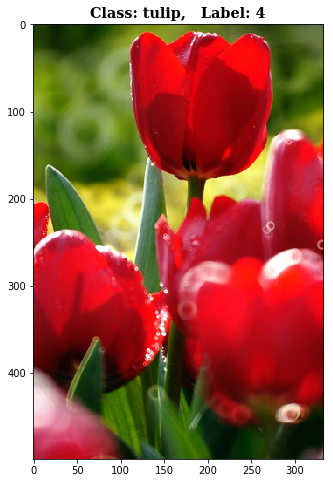

In [590]:
base_image = cv.imread(image, cv.IMREAD_COLOR)
base_image = cv.cvtColor(base_image, cv.COLOR_BGR2RGB)
print(f'Image dimentions: {base_image.shape}')
print(f'Class name: {classes[label]}')
print(f'Label: {label}')

title = f'Class: {classes[label]},   Label: {label}'
fontdict = {
    'fontsize': 'x-large',
    'fontweight': 'bold',
    'family': 'serif'
}

fig = plt.figure(figsize=(8, 8))
plt.imshow(base_image)
_  = plt.title(title, fontdict)

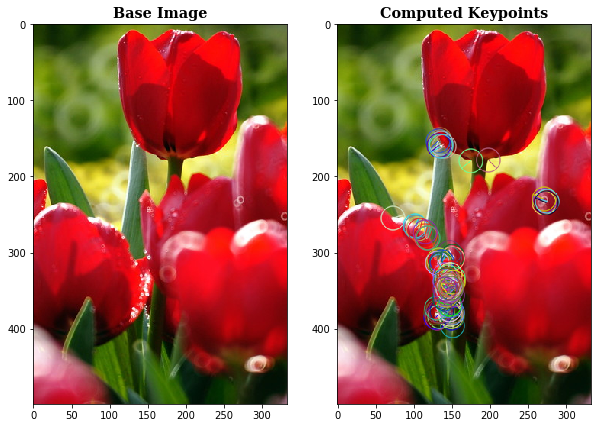

In [591]:
"""
Generate cool visuals displaying the keypoints
"""
# create detector
orb = cv.ORB_create()

# find the keypoints compute the descriptors
kp, des = orb.detectAndCompute(base_image, None)

flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
base_img = cv.imread(image, cv.IMREAD_COLOR)
base_img = cv.cvtColor(base_img, cv.COLOR_BGR2RGB)
rich_img = cv.imread(image, cv.IMREAD_COLOR)
rich_img = cv.cvtColor(rich_img, cv.COLOR_BGR2RGB)

# Draw kpts
_ = cv.drawKeypoints(base_img, kp[:75], 
                     rich_img, flags=flags)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(base_img)
ax[0].set_title('Base Image', fontdict=fontdict)
ax[1].imshow(Image.fromarray(rich_img))
_ = ax[1].set_title('Computed Keypoints', fontdict=fontdict)

In [592]:
def get_matches(query, db_image, detector, ratio=0.7):
    kps1, des1 = detector.detectAndCompute(query, None)
    kps2, des2 = detector.detectAndCompute(db_image, None)
    
    # Find Similarities
    FLANN_INDEX_LINEAR = 0
    FLANN_INDEX_KDTREE = 1
    FLANN_INDEX_KMEANS = 2
    FLANN_INDEX_COMPOSITE = 3
    FLANN_INDEX_KDTREE_SINGLE = 4
    FLANN_INDEX_HIERARCHICAL = 5
    FLANN_INDEX_LSH = 6
    FLANN_INDEX_SAVED = 254
    FLANN_INDEX_AUTOTUNED = 255
    index_params = dict(algorithm=FLANN_INDEX_KDTREE)
    search_params = dict(checks=50)

    try:
        flann = cv.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(des1.astype(np.float32), 
                                 des2.astype(np.float32), k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m, n in matches:
            if m.distance < ratio*n.distance:
                good.append(m)
    except:
        good = []
    
    return kps1, kps2, good

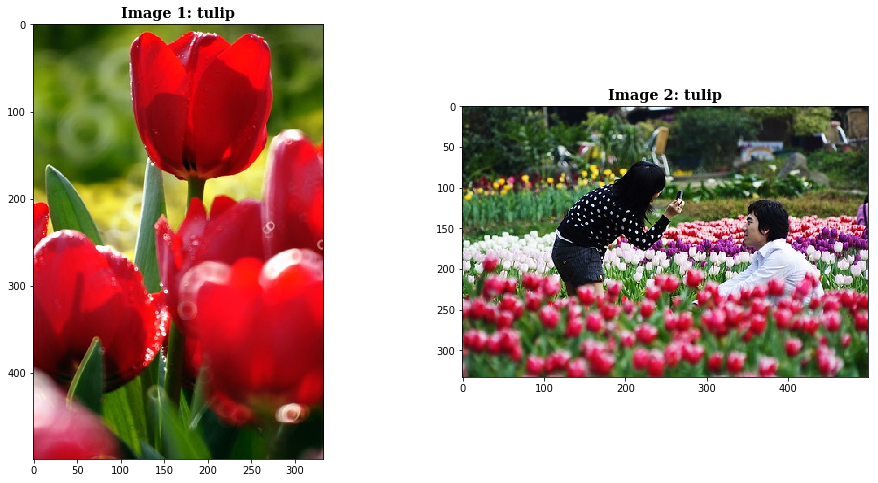

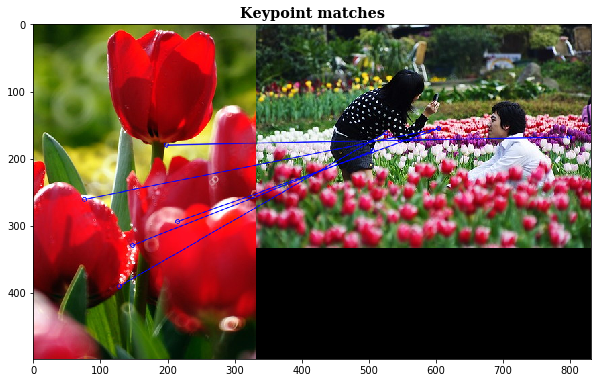

In [594]:
"""
Those were some cool visuals, but how is this helpful?
"""
image1, label1 = dataset[-2]
image2, label2 = dataset[-3]

base1 = cv.imread(image1, cv.IMREAD_COLOR)
base2 = cv.imread(image2, cv.IMREAD_COLOR)

base1 = cv.cvtColor(base1, cv.COLOR_BGR2RGB)
base2 = cv.cvtColor(base2, cv.COLOR_BGR2RGB)

gray1 = cv.imread(image1, cv.IMREAD_GRAYSCALE)
gray2 = cv.imread(image2, cv.IMREAD_GRAYSCALE)

MIN_MATCH_COUNT = 5

kps1, kps2, matches = get_matches(gray1, gray2, orb, ratio=0.80)
matchesMask = get_inliers(matches, MIN_MATCH_COUNT)

if matchesMask == None:
    print(f"Not enough matches are found - {len(matches)}/{MIN_MATCH_COUNT}")    
else:
    # Draw kpts
    flags = cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS
    draw_params = dict(matchColor = (0,0,255), # draw matches in blue color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = flags)

    rich_img = cv.drawMatches(base1, kps1,
                              base2, kps2,
                              matches, None,
                              **draw_params)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(base1)
    ax[1].imshow(base2)
    ax[0].set_title(f'Image 1: {classes[label1]}', fontdict=fontdict)
    ax[1].set_title(f'Image 2: {classes[label2]}', fontdict=fontdict)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.set_title('Keypoint matches', fontdict=fontdict)
    _ = ax.imshow(rich_img)

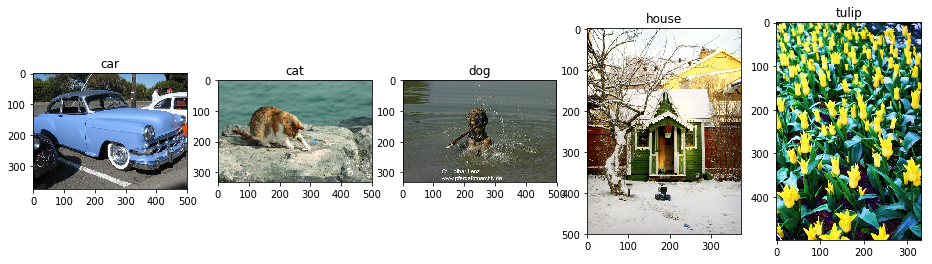

In [595]:
"""
Now that we have a basic understanding on how this works,
lets try to perform a search though our databae using an 
example image.

Notes:
query image = The image that will be use as an example
database = A repository of images. It could just be a 
           directory with an array of images. It does 
           not have to be an SQL or NoSQL database.
"""

# First lets pick five images at random.
# To keep it interesting, there will be 
# no duplicate classes or images.

# Make experiment replicable
seed = 42
np.random.seed(seed)
random.seed(seed)

images_per_class = len(dataset)//len(classes) - 1
random_index = np.random.randint(0, images_per_class)
query_indexes = np.arange(random_index, len(dataset), step=images_per_class+1)
query_indexes = np.random.choice(query_indexes, size=5, replace=False)
query_indexes.sort()

database_indexes = []

ix_database = list(range(0, len(dataset)))

for index in query_indexes[::-1]:
    ix_database.pop(index)
    
# Lets see which images we got
fig, axs = plt.subplots(1,5, figsize=(16,4))

for i, ax in enumerate(axs):
    image_index = query_indexes[i]
    image, label = dataset[image_index]
    image = cv.imread(image, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    ax.set_title(classes[label])
    ax.imshow(image)

In [596]:
# Then we will get the keypoint and descriptors for all our images
flat_kps = [] # flat keypoints
flat_des = [] # flat descriptors

acc_ix = [0] # accumulated keypoints

for image, _ in dataset:
    gray_image = cv.imread(image, cv.IMREAD_GRAYSCALE)
    kps, des = orb.detectAndCompute(gray_image, None)
    
    if len(kps) <= 0:
        kps = [None]
        des = [None]
    
    flat_kps.extend(kps)
    flat_des.extend(des)
    acc_ix.append(len(kps))

"""
The keypoints variable is a list of lists.
This brings probles that we will address
later on the tutorial.

What we want is a flat list of all keypoints.
The problem with having a flat list is that we
have no way to map back to the image for which
the keypoints belong to.
"""
acc_ix = np.array(list(accumulate(acc_ix)))
acc_ix[-1], len(flat_kps)

(77272, 77272)

In [605]:
"""
Compare every query keypoint against the database keypoints
and store the index of the top K nearest kps for each class.
"""
query_kps = []
database_kps = []

k_distances = []

for ix in query_indexes:
    start, stop = get_boundaries(acc_ix[ix], acc_ix)
    query_kps.append(flat_kps[start:stop])

for ix in ix_database:
    start, stop = get_boundaries(acc_ix[ix], acc_ix)
    database_kps.extend(flat_kps[start:stop])

database_points = get_point_mat(database_kps)

for image_kps in tqdm(query_kps):
#     k_distances.append(get_image_distance(image_kps, database_kps, k=1))
    k_distances.append(get_image_distance(image_kps, flat_kps, k=1))


100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

In [606]:
"""
To-Do: Get all of the the original image keypoints for each of the top
       1000 keypoints and select the top 5 database images for each class
"""

unique_indexes = []

# Get bounaries for all indexes
for image in k_distances:
    unique = set()
    for index_list in image:
        for index in index_list:
            unique.add(get_dataset_index(index, acc_ix))
    unique = list(unique)
    unique_indexes.append(unique)

In [607]:
len(unique_indexes[0]), len(unique_indexes[1]), len(unique_indexes[2]), \
len(unique_indexes[3]), len(unique_indexes[4])

(45, 57, 63, 38, 56)

In [647]:
resutls = []
k = 5
for i, query_index in enumerate(query_indexes):
    query_image, query_label = dataset[query_index]
    query_image = cv.imread(query_image, cv.IMREAD_GRAYSCALE)
    match_list = []  
    for j in unique_indexes[i]:
#         j = ix_database[j]
        db_image, db_label = dataset[j]
        db_image = cv.imread(db_image, cv.IMREAD_GRAYSCALE)

        kps1, kps2, matches = get_matches(query_image, db_image, orb, ratio=0.80)
        
        if len(matches) > 0:
            match_list.append([len(matches), j, db_label])
    
    match_list = np.array(match_list)
    top_k = match_list[np.argsort(match_list, axis=0)[-k:, 0]]
    resutls.append(top_k[::-1])
    matches = (query_label == resutls[-1][:, -1]).sum()
    print(f'{matches}/{k} {classes[query_label]} found')

2/5 car found
1/5 cat found
1/5 dog found
1/5 house found
3/5 tulip found


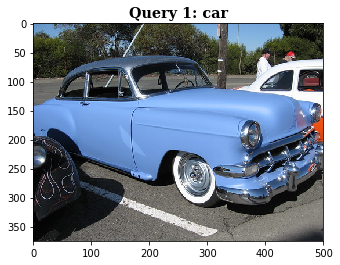

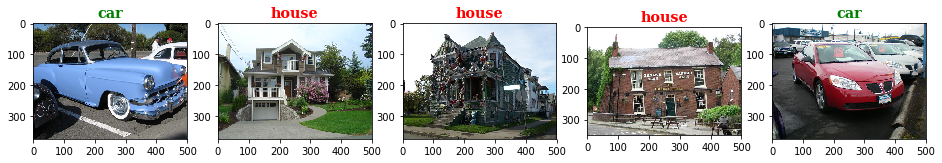

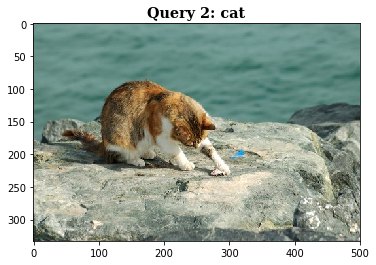

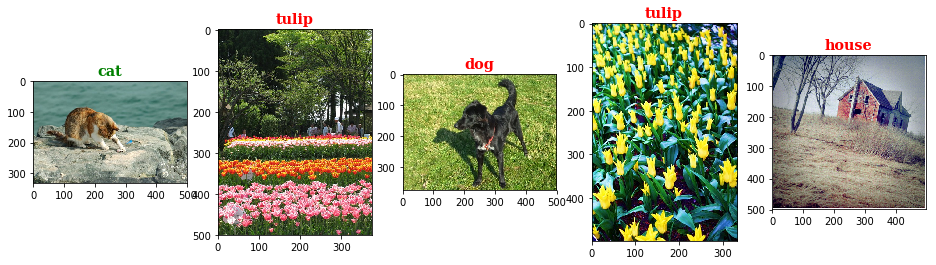

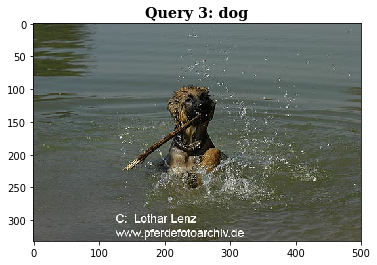

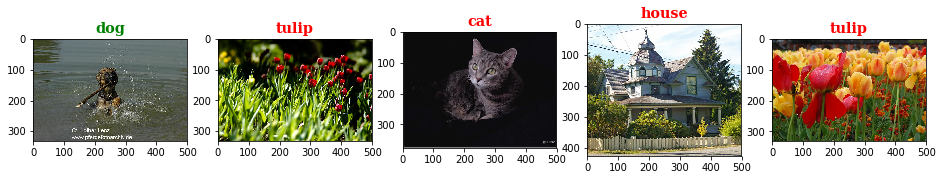

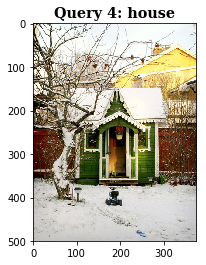

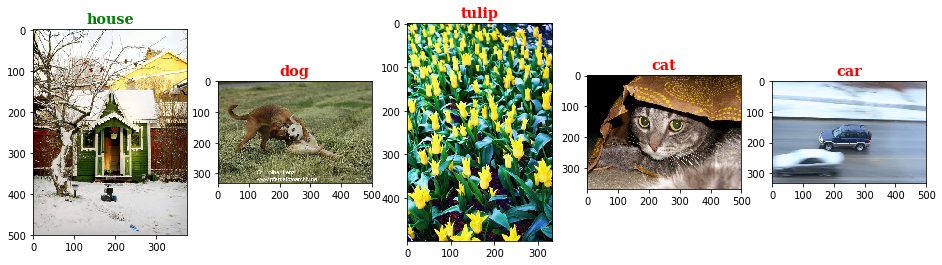

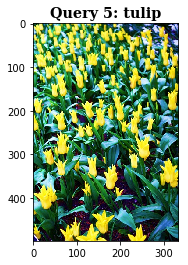

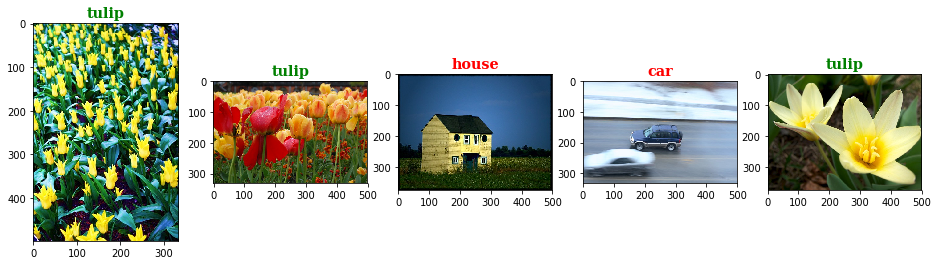

In [665]:
# Lets see which images we got

for i, result in enumerate(resutls):
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    qimage_path, qlabel = dataset[query_indexes[i]]
    image = cv.imread(qimage_path, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    fontdict['color'] = 'black'
    ax.set_title(f'Query {i+1}: {classes[qlabel]}', fontdict=fontdict)
    ax.imshow(image)
    
    
    fig, axs = plt.subplots(1,5, figsize=(16,4))
    for j, (_, index, _) in enumerate(result):
        dbimage, dblabel = dataset[index]
        image = cv.imread(dbimage, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        ax = axs[j]
        
        if qlabel == dblabel:
            fontdict['color'] = 'green'
        else:
            fontdict['color'] = 'red'
        
        ax.set_title(classes[dblabel], fontdict=fontdict)
        ax.imshow(image)